<a href="https://colab.research.google.com/github/kindeerrrr/first_repository/blob/main/prodv_dz_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import find_peaks
from scipy.fft import fft
from tensorflow.keras.layers import BatchNormalization


Загружаю тренировочные изображения и их метки. Тестовые изображения почему-то с pickle, поэтому добавляю флаг. Перевожу тестовые картинки в массив, чтобы с ними удобно было работать дальше

In [44]:
# Загружаем обычные данные
images = np.load('images.npy')
labels = np.load('labels.npy')

# Загружаем images_sub.npy с поддержкой pickle
test_images_raw = np.load('images_sub.npy', allow_pickle=True)

# Преобразуем в массив (если это список изображений)
test_images = np.array([img for img in test_images_raw])

print("Форма test_images:", test_images.shape)
print("Тип test_images:", test_images.dtype)

Форма test_images: (50000, 48, 48, 3)
Тип test_images: uint8


На всякий случай посмотрела, как вообще выглядят мои данные. Вывела 10 первых изображений и поставила буквы на них, чтобы понять, соответствует ли label реальной картинке. Все ок

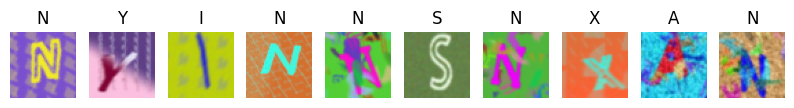

In [45]:
plt.figure(figsize=(10, 3))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.title(chr(65 + labels[i]))  # A-Z
    plt.axis('off')
plt.show()

Нормализую изображения — делю на 255, чтобы пиксели были в диапазоне от 0 до 1 (это нужно, чтобы нейросеть не сошла с ума). Делю на тренировку и валидацию, чтобы потом можно было честно проверить, как она учится

In [46]:
# Нормализация пикселей (от 0 до 1) и разделение данных
images = images / 255.0
test_images = test_images / 255.0

# делим на train/val для оценки
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

Собрала CNN — обычная сверточная сетка с нормализациями, пуллингами и дропаутами. Увеличиваю глубину по слоям: 32 → 64 → 128. В конце — плотный слой и выход на 26 классов (буквы от A до Z).
Dropout нужен, чтобы не переобучалась. BatchNormalization — чтобы быстрее и стабильнее училась

In [47]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(26, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Выбираю оптимизатор adam — он стабильный и не требует ручного подбора learning rate. Потеря — sparse_categorical_crossentropy, потому что у меня целочисленные метки классов. Метрика — accuracy, это то, что будем отслеживать

In [48]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Запускаю тренировку на 13 эпох с батчем 64. Смотрю, как меняется точность на тренировке и валидации

In [49]:
history = model.fit(X_train, y_train, epochs=13, batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 385ms/step - accuracy: 0.0432 - loss: 3.6657 - val_accuracy: 0.0373 - val_loss: 7.0773
Epoch 2/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 363ms/step - accuracy: 0.0527 - loss: 3.2490 - val_accuracy: 0.0465 - val_loss: 4.0448
Epoch 3/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 148s 389ms/step - accuracy: 0.0525 - loss: 3.2247 - val_accuracy: 0.0693 - val_loss: 3.2219
Epoch 4/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 139s 378ms/step - accuracy: 0.0642 - loss: 3.1744 - val_accuracy: 0.1290 - val_loss: 2.9681
Epoch 5/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 364ms/step - accuracy: 0.1125 - loss: 2.9446 - val_accuracy: 0.2910 - val_loss: 2.3261
Epoch 6/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 380ms/step - accuracy: 0.2221 - loss: 2.5477 - val_accuracy: 0.4025 - val_loss: 1.9398
Epoch 7/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 360ms/step - accuracy: 0.3117 - loss: 2.2105 - val_accuracy: 0.4645 - val_loss: 1.7722
Epoch 8/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 375ms/step - accuracy: 0.4081 -

Рисую, как менялась точность на обучении и валидации по эпохам. Полезно, чтобы понять, переобучилась модель или всё норм


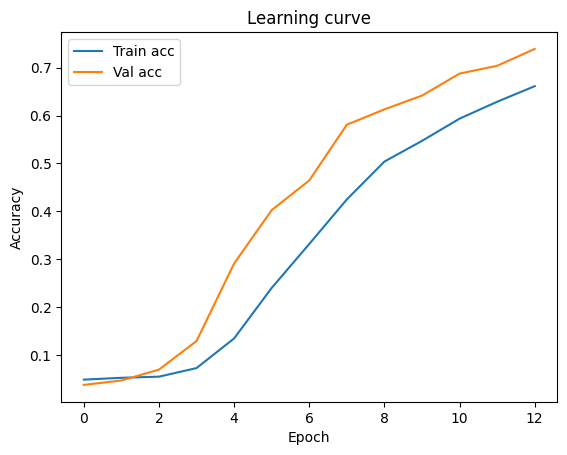

In [50]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning curve')
plt.show()

Прогоняю тестовые изображения через модель, получаю вероятности по всем классам. Аргмаксимом достаю индекс класса — это и есть наша предсказанная буква

In [51]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step


Подгружаю шаблон отправки, вставляю свои предсказания в нужную колонку. Убираю всё лишнее и сохраняю файл

In [52]:
import pandas as pd

# Загружаем шаблон
submission = pd.read_csv('sample_submission.csv')
submission['Category'] = predicted_labels

# Оставляем только нужные колонки
submission_final = submission[['Id', 'Category']]

# Сохраняем файл
submission_final.to_csv('submission.csv', index=False)

Итоги:

Получила результат 0,74, взяв 13 эпох, вместо 10. В идеале попробовать еще больше и посмотреть, как будет себя вести, но мой комп не особо тянет такие штуки и слишком долго приходится ждать (свыше 30 минут)

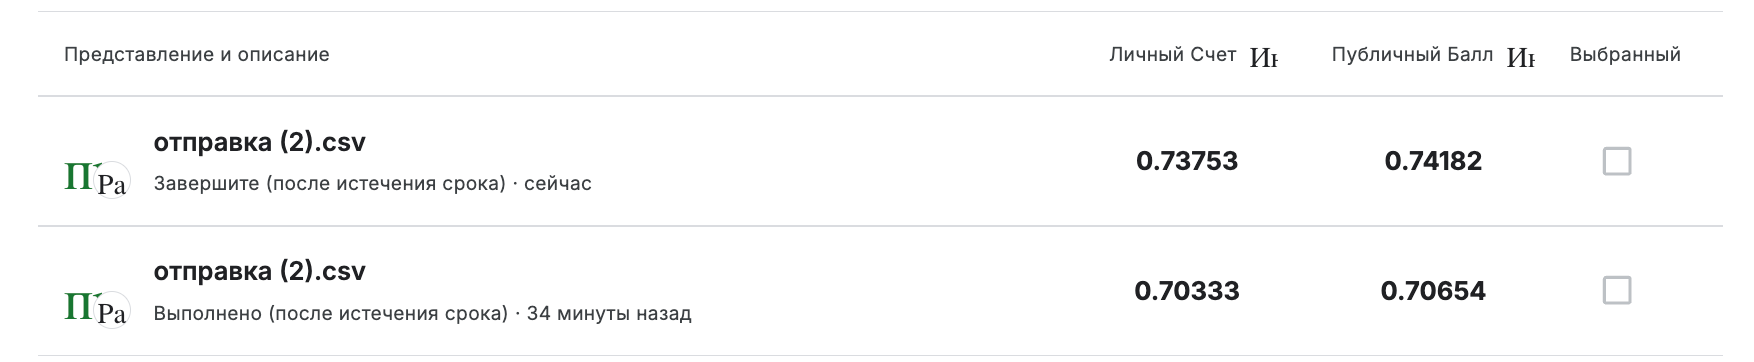